# Russian Troll-Tweet Identifier

This project uses a [Kaggle dataset](https://www.kaggle.com/vikasg/russian-troll-tweets) of 200,000 Tweets captured by NBC during the 2016 presidential election, which are known to be of malicious intent. However, as a 2016 political troll, the goal was to stir up as much polarization as possible while blending in as an average American citizen. 
<br><br>
I attempt to train various sci-kit learn machine learning algorithims to classify a tweet as a troll (True) or a non-troll (False). In doing so, I add in certain features that touch on certain qualities of grammar patterns within non-native English speakers, as well as the intent behind a "troll tweet".

In [1]:
import pandas as pd
import sklearn
import os

## Preparing Main Datasets

In [2]:
df = pd.read_csv("/Users/parkerglenn/Desktop/russian-troll-tweets/tweets.csv")
df = df[["user_key","hashtags","text","mentions"]]
#Just because the data is so uneven right now
df = df.drop(df.index[:200000])

For the non-troll set of tweets, a total of 3,476 tweets from 14 accounts were scraped using BeautifulSoup and the Twitter API. This was originally used for my LING 111 project, but below is the code. 

In [ ]:
import tweepy
 
# Consumer keys and access tokens, used for OAuth
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''
 
# OAuth process, using the keys and tokens
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
 
# Creation of the actual interface, using authentication
api = tweepy.API(auth)
 
accounts = ['realDonaldTrump','SamuelLJackson', 'KimKardashian', 'BarackObama',
                    'TheEllenShow', 'Oprah', 'jtimberlake', 'ladygaga', 'ArianaGrande',
                    'justinbieber', 'OzzyOsbourne', 'SofiaVergara', 'shakira', 'britneyspears' ]

# gets the last 200 tweets of a person, prints 
with open("TwitterCorpus.txt", "w") as f:
    for person in accounts:
        tweet= api.user_timeline(screen_name=person,count=200,tweet_mode="extended") 
        for status in tweet:
            f.write(status._json['full_text'] + '\n') # writes the text in file 

Turning the json into a dictionary format:

In [ ]:
# changes a newline separated text into a python dictionary format
with open('TwitterCorpus.txt', 'r') as f: 
    with open('TwitterCorpusFormatted.py', 'w') as f2:
        f2.write('TwitterCorpus = {')
        counter = 1
        for line in f.readlines():
            f2.write('\'Twitter_' + str(counter) + '\':\'')
            counter += 1
            f2.write(line.strip().replace('\'', '\\\'') + '\',') # escape quote marks so they won't be treated as close quotes
        f2.write('}')

In [3]:
os.chdir("/Users/parkerglenn/Desktop/UCSB/ComputationalLinguistics/FinalProject")
from TwitterCorpusFormatted import TwitterCorpus

tweets = []
for i in TwitterCorpus.values():
    tweets.append(i)

In [1174]:
print("There are {} tweets in the troll set, and {} in the non-troll set".format(len(df),len(TwitterCorpus)))

There are 3482 tweets in the troll set, and 3476 in the non-troll set


Despite starting out with the 200,000 Kaggle tweets, I use only 3,482 for efficiency and to match the non-troll set.

In [4]:
good = pd.DataFrame(tweet for tweet in TwitterCorpus.values())

good.columns = ["text"]
good["trolliness"] = False
df["trolliness"] = True
df = df.append(good, sort = False)

In [5]:
df.head()

,user_key,hashtags,text,mentions,trolliness
200000,mr_clampin,[],RT @GeffGefferson1: Thank You!!! https://t.co/...,[],True
200001,johnbranchh,[],RT @blicqer: Former Auburn star joins Buccanee...,[],True
200002,brightandglory,"[""TrumpsFavoriteHeadline""]",RT @DanaGeezus: #TrumpsFavoriteHeadline List O...,"[""danageezus""]",True
200003,cookncooks,"[""Brussels""]",#Brussels #IslamKills Syrian refugees are not ...,[],True
200004,paulinett,[],RT @blicqer: Nicki Minaj's Harasses Homeless W...,[],True


# Machine Learning

As I defined "success" in this project, I include the Precision score on top of the F1 score because of its importance in this task. Since precision puts great weight false positives, it offers a gauge of potential repurcussions; in this instance a false positive would be a non-troll account being flagged as a troll account, a situation that would get Twitter in very hot water.

In [1064]:
def success(*kwargs):
    for column in kwargs:
        print("Scores for model", column)
        print("Classification accuracy:", sklearn.metrics.accuracy_score(output.Actual, output[column]))
        print("F1 score:", sklearn.metrics.f1_score(output.Actual, output[column], average = "micro"))
        print("Precision:", sklearn.metrics.precision_score(output.Actual, output[column], average = "micro"))
        print("Matthews coefficient:", sklearn.metrics.matthews_corrcoef(output.Actual, output[column]))
        print()
def success2(*kwargs):
    for column in kwargs:
        print("Scores for model", column)
        print("Classification accuracy:", sklearn.metrics.accuracy_score(output2.Actual, output2[column]))
        print("F1 score:", sklearn.metrics.f1_score(output2.Actual, output2[column], average = "micro"))
        print("Precision:", sklearn.metrics.precision_score(output2.Actual, output2[column], average = "micro"))
        print("Matthews coefficient:", sklearn.metrics.matthews_corrcoef(output2.Actual, output2[column]))
        print()

In [1065]:
import sklearn
from sklearn.naive_bayes import MultinomialNB
import sklearn.pipeline

### Basic MNB Model

In [1066]:
train,test = sklearn.model_selection.train_test_split(df)
output = pd.DataFrame(
    {
        "Actual": test.trolliness
    })

In [1070]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = "english")
mnb = MultinomialNB()

default_pipeline = sklearn.pipeline.make_pipeline(
    vectorizer,
    mnb,
)

default_pipeline.fit(train.text,train.trolliness)    
output["default_MNB"] = default_pipeline.predict(test.text)

success("default_MNB")

Scores for model default_MNB
Classification accuracy: 0.8781609195402299
F1 score: 0.8781609195402299
Precision: 0.8781609195402299
Matthews coefficient: 0.7567111872549714



### MNB Model with Entity Tokenization

Below this I modify a named entity recognition that I've used in the past to fit this data. It tokenizes a choses subset of Spacy's ents as a single token, if it was previously a multi-token term. For example, "United Nations" would be tokenized as one whole token, rather than the typical "united","nations" distribution.

In [1179]:
# For my ner tokenizer
from nltk.corpus import stopwords
import spacy
from spacy.gold import iob_to_biluo
nlp = spacy.load('en_core_web_md', disable=['parser','tagger','textcat'])
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
english_stopwords = stopwords.words('english')

def ent_tokenizer(text):    
    good_ents = ["PERSON","GPE","ORG", "LOC", "EVENT", "FAC", ]
    continue_tags = ["B-","I-"]
    end_tags = ["L-","U-"]
    
    toks = []
    iobs = [i.ent_iob_ for i in nlp(text)]
    biluos = list(iob_to_biluo(iobs))
    index = -1
    #Named entities variable
    ne = ""
    
    for tok in nlp(text):
        index += 1
        if biluos[index] in continue_tags and str(tok.ent_type_) in good_ents:
            #str(tok).split() != [] Checks if empty token
            #For some reason tok.whitespace_ doesn't include double token entities
            #like "JENNIFER LAWRENCE"
            if str(tok).split() != []:
                ne += " " + str(tok)
        elif biluos[index] in end_tags and str(tok.ent_type_) in good_ents:
            if str(tok).split() != []:
                ne += " " + str(tok)
                toks.append(ne.lstrip())
                ne = " "
        #If token is just a boring old word
        else:
            if tok.is_punct == False and tok.is_space == False and str(tok).lower() not in english_stopwords and not (str(tok)[0] == '@' or str(tok)[0] == '#' or str(tok).startswith('http') or str(tok).startswith('www')):
                toks.append(str(tok).lower())
    return toks

In [1178]:
t = [ent_tokenizer(df.text.loc[123])]
t

[['funny',
  'see',
  'little',
  'Adam Schitt',
  'ca',
  'talking',
  'fact',
  'acting',
  'attorney',
  'general',
  'Matt Whitaker',
  'approved',
  'Senate',
  'mentioning',
  'fact',
  'Bob Mueller',
  'highly',
  'conflicted',
  'approved',
  'Senate']]

Notice how, in the above example, names ("Bob Mueller","Matt Whitaker") are successfully identified as an entity, and appropriately merged into a single token.

### NOTE: the below cell of code takes a while to run, since it's relying on Spacy's NER 

In [1180]:
ent_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(tokenizer = ent_tokenizer)
mnb = MultinomialNB()
ent_pipeline = sklearn.pipeline.make_pipeline(
    ent_vectorizer,
    mnb,
)

ent_pipeline.fit(train.text,train.trolliness)    
output["ent_MNB"] = ent_pipeline.predict(test.text)

success("default_MNB", "ent_MNB")

Scores for model default_MNB
Classification accuracy: 0.8781609195402299
F1 score: 0.8781609195402299
Precision: 0.8781609195402299
Matthews coefficient: 0.7567111872549714

Scores for model ent_MNB
Classification accuracy: 0.8844827586206897
F1 score: 0.8844827586206897
Precision: 0.8844827586206897
Matthews coefficient: 0.7692739700805095



So adding in entity tokenization helped a bit, but not a significant amount. Because the result wasn't some crazy improvement, in the future examples I use a more traditional tokenizer to avoid the processing times that come with Spacy's NER.

# Embedding Grammar Features

To further assist the sci-kit models in identifying troll tweets, I began to look for grammatical clues in the framework of the tweets. Essentially, the two features described below center around the idea that non-native English speakers, specifically native Russian speakers, often struggle with correctly utilizing English articles (a, an, the), along with other stop words. 
<br/><br/>
The dataset used to calibrate the grammar features is from LING 110. It's a set of transcriptions from a senate hearing.

### Preparing Data

In [1072]:
import glob
import re
files = glob.glob("/Users/parkerglenn/Desktop/russian-troll-tweets/CapitolWords/*.txt")
capitol = []
for file in files:
    new = open(file)
    capitol.append(new.read())
    new.close()

# Just becuase there's so many. My computer can't handle everything. 
capitol = capitol[:5000]

In [1169]:
print(capitol[5])

I yield myself an additional 30 seconds.
It is restrictive in some respects; in some it is not. We do not require in the first 5 years -- in the original bill you have to do these reviews and have to provide some service, so that is not the same. The Breaux amendment in fact goes further. In the second 5 years there was an allowance in the conference report, I believe, and I can check on that, that after 5 years they could use Federal funds.


In [1185]:
def tokenize_tweets(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        # Takes out tags, hashtags, and urls
        if not (token[0] == '@' or token[0] == '#' or token.startswith('http') or token.startswith('www')):
            # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
    return filtered_tokens

## Calculating "stop_score"
Studies have shown that non-native English speakers tend to use stop words at a less frequent rate than native English speakers. Intuitively, this makes sense; they're tiny grammatical particles that, to the casual learner of English, may not seem as important as the "big" vocab words. 
<br/><br/>
To calculate "stop_score" as a feature, the average stopword usage per a sentence of x-length is calculated across the senate hearing transcripts. Then, the amount of stopwords in a tweet of X-length is calculated, and:
<br/><br/>**stop_score = (stopwords in a tweet of xlength) - (avg. stopwords in a sentence of xlength)**

In [1193]:
import nltk
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')
tokenizer = nltk.tokenize.TweetTokenizer()

sent_dict = {}
for text in capitol:
    sents = [sent for sent in nltk.sent_tokenize(text)]
    for sent in sents:
        toks = [word for word in tokenizer.tokenize(sent)]
        try:
            sent_dict[len(toks)]
        except KeyError:
            sent_dict[len(toks)] = []
        stops = 0
        for tok in toks:
            if tok in english_stopwords:
                stops += 1
        sent_dict[len(toks)].append(stops)
   
# Calculates average amount of stopwords for a sentence of x length     
for k in sent_dict:
    sent_dict[k] = sum(sent_dict[k]) / len(sent_dict[k])

In [1194]:
bad_words = ["RT","@","https","//"]
stop_scores = []
for place, tweet in enumerate(df.text):
    score = 0
    sents = [sent for sent in nltk.sent_tokenize(tweet)]
    for sent in sents:
        toks = [word for word in tokenizer.tokenize(sent) if word not in bad_words and word.isalpha()]
        count = 0
        for tok in toks:
            if tok in english_stopwords:
                count += 1
        try:
            score += count - sent_dict[len(toks)]
        except:
            pass
    stop_scores.append(score)
df["stop_score"] = stop_scores

I classify the stop_scores into 3 groups called "suspicion," as those scores with lower values are more suspicious. I end up not using this as a feature though, and just go with the raw "stop_score".

In [1076]:
def stops_group(x):
    if x > -2:
        return(0)
    if x < -1.1 and x > -4:
        return(1)
    if x < -4:
        return(2)
df["suspicion"] = [stops_group(x) for x in df.stop_score]

In [1196]:
df[["text","stop_score","trolliness"]]

,text,stop_score,trolliness
200000,RT @GeffGefferson1: Thank You!!! https://t.co/I4ravmchMy,-0.001168,True
200001,RT @blicqer: Former Auburn star joins Buccaneers after promising to help his homeless mom https://t.co/QRnvFfJufu @NewPghCourier https://t.…,-1.495528,True
200002,RT @DanaGeezus: #TrumpsFavoriteHeadline List Of Best People Released. Trump no1,-1.394577,True
200003,#Brussels #IslamKills Syrian refugees are not welcome in my neighborhood! You garbage Liberal!,0.841558,True
200004,RT @blicqer: Nicki Minaj's Harasses Homeless Woman With Mental Illness https://t.co/d7S17rgbry @Thought_Crimez https://t.co/WcIBAOFnP6,-2.412750,True
200005,"RT @Fusion: Donald Trump was apparently so surprised to see a black person at his rally, he didn't recognize him as a supporter—and called…",2.303869,True
200006,Italienisches Parlament stimmt für Militäreinsatz vor Libyen. Aber die #Flüchtlinge werden neue Wege finden!\r\nhttps://t.co/h5jDICWktg,-4.325325,True
200007,"RT @Counselor70: @eff_dblu_ell @colavs2184 CNN &amp; MSM TELL TRUTH OR GET THE FUCK OUT, THE\r\nSTENCH OF LIARS Those Bias Bastards https://t.co/d…",-6.156216,True
200008,RT @fedbizop: #ItsRiskyTo get this hash tag confused with the Run DMC song It's Tricky.,-1.067153,True
200009,RT @RT_America: WaPo begs people to stop saying 'fake news' after they started it all [VIDEO] https://t.co/Dseyo075fM @TheResident https://…,-0.231892,True


<function matplotlib.pyplot.show(*args, **kw)>

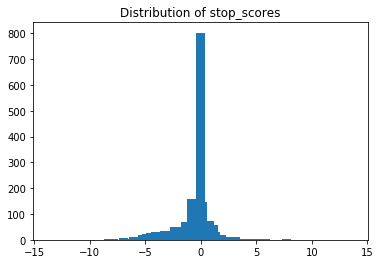

In [1077]:
import matplotlib.pyplot as plt
plt.bar(scores.keys(), scores.values())
plt.title("Distribution of stop_scores")
plt.show

The leftward-skewing in the bargraph above implies that most tweets use less-than average amounts of stopwords per sentence. This may be partly due to the typically terse, informal context of the sentences (tweets) as opposed to the more formal context of the calibration corpus (senate hearing). 

## Calculating "mistake" Score

The process detailed below is based on the fact that in the Russian language, both indefinite and definite articles are not present. As a result, the absence of such articles in English result in awkward speech by non-native speakers (ex. "I took *train* to Washington"). This incorrect grammatical structure is tough to define based solely on parts of speech, since some nouns require an article preceding it, while others don't (ex. "I drank *water* before my run"). A markov-like process was used to calculate the percentage of instances a specific noun was preceded by an article, and this percentage is used to flag incorrect grammar. 
<br/><br/> **mistakes = integer value of perceived grammar "errors"**

In [1101]:
articles = ["a","an","the","this","that","those","these"]

I admit, I included the demonstrative pronouns "this, that, these" and "those" in a list titles "articles." But after analyzing the tweets and examining the results of using strictly articles vs. the revised list found above, this iteration seemed to provide more polarizing, helpful results.

In [1182]:
tweet_toks = []
# Part of speech list is created for future use
toks_pos = []
def tokenizer(text):
    toks = []
    pos = []
    text = text.lower()
    for tok in nlp(text):
        if tok.is_punct == False and tok.is_space == False:
            pos.append(str(tok.pos_))
            toks.append(str(tok))
    tweet_toks.append(toks)
    toks_pos.append(pos)

In [ ]:
for text in capitol:
    tokenizer(text)

In [632]:
grammar_dict = []
for transcript_place, transcript in enumerate(text_toks): 
    for word_place, word in enumerate(transcript):
        if word in articles: 
            try:
                # If the word following the article is a noun
                if toks_pos[transcript_place][word_place + 1] == "NOUN":
                    # Then add that noun to the grammar_dict
                    grammar_dict.append(transcript[word_place + 1].lower())
            except IndexError:
                pass
            try:
                # Below catches instance of phrases like "he is a great candidate", where an adjective seperates noun and article.
                if toks_pos[transcript_place][word_place + 1] == "ADJ" and toks_pos[transcript_place][word_place + 2] == "NOUN":
                    grammar_dict.append(transcript[word_place + 2].lower())
            except IndexError:
                pass
from collections import Counter
grammar_dict = dict(Counter(grammar_dict))

In [633]:
# This counts all occurences of the nouns in grammar_dict, regardless of if they are preceded by an article.
count_dict = []
for transcript in text_toks:
    for tok in transcript:
        if tok.lower() in list(grammar_dict.keys()):
            count_dict.append(tok.lower())
count_dict = dict(Counter(count_dict))

Below invokes the idea of ratio-ing: Out of all the times that a specific noun is used, what percentage of times is it preceded by an article?

In [634]:
for word in grammar_dict:
    try:
        grammar_dict[word] = grammar_dict[word] / count_dict[word]
    except:
        print(word)

In [635]:
#f = open("/Users/parkerglenn/Desktop/russian-troll-tweets/grammar_dict_WITHPRONOUNS.py","w")
#f.write("grammar_dict = " + str(grammar_dict))       

259097

In [1106]:
grammar_dict

{'levin': 0.24786324786324787,
 'cosponsor': 0.6854838709677419,
 'moment': 0.9125799573560768,
 'debate': 0.6253443526170799,
 'members': 0.1877282688093499,
 'body': 0.8542976939203354,
 'status': 0.3623693379790941,
 'president': 0.35006817900086773,
 'hue': 1.0,
 'failures': 0.46153846153846156,
 'administration': 0.5950468540829986,
 'execution': 0.45454545454545453,
 'side': 0.6694473409801877,
 'aisle': 0.9973474801061007,
 'kinds': 0.4144736842105263,
 'roadmap': 1.0,
 'balance': 0.32558139534883723,
 'strategy': 0.5050505050505051,
 'problems': 0.347239263803681,
 'iraqis': 0.5864197530864198,
 'refuge': 0.2903225806451613,
 'solution': 0.7090301003344481,
 'date': 0.6146788990825688,
 'consequences': 0.45161290322580644,
 'way': 0.703678001387925,
 'troops': 0.12338593974175036,
 'region': 0.7866666666666666,
 'world': 0.8292087835482747,
 'turning': 0.06451612903225806,
 'who': 0.10447170557973882,
 'change': 0.14052953156822812,
 'direction': 0.7991803278688525,
 'chances':

In [1109]:
# Re-loading Spacy because I had previously disabled the "tagger" that I now need
nlp = spacy.load('en_core_web_md', disable=['parser','ner','textcat'])
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)

12

After many iterations, 0.75 is the value that I ended up using for the "threshold" because of the contrast I got between troll mistakes and non-troll mistakes.

In [1110]:
tokenizer = nltk.tokenize.TweetTokenizer()
# This threshold is the cutoff for what is considered a "mistake"
threshold = .75
grammar_errors = []
bad_words = []
for tweet_place, tweet in enumerate(df.text):
    bad_words_tweet = []
    errors = 0
    toks = tokenizer.tokenize(tweet)  
    for tok_place, tok in enumerate(toks):  
        tok = tok.lower()
        try:
            if toks[tok_place-1].lower() not in articles and toks[tok_place-2].lower() not in articles and tok in list(grammar_dict.keys()) and grammar_dict[tok] >= threshold:
                # Checks to be sure the word functions as a noun. Only takes a small sample of the tweet to save time  
                sent = ""
                for x in range(-2,2):
                    sent += toks[tok_place + x].lower()
                    sent += " "  
                for word in nlp(sent):
                    if str(word) == tok:
                        pos = str(word.pos_)
                # Only if the word functions as a noun is it counted as an error.
                # Before this, the phrase "cowboy boots" was getting flagged despite it being
                # grammatically correct ("cowboy" acts as an adjective here)
                if pos == "NOUN":     
                    errors += 1
                    bad_words_tweet.append(tok)
        except IndexError:
            pass
    grammar_errors.append(errors)
    bad_words.append(bad_words_tweet)
df["grammar_errors"] = grammar_errors
df["bad_words"] = bad_words

In [1111]:
oops = df.loc[df.grammar_errors > 0]
print("There are " + str(len(oops.loc[oops.trolliness == True])) + " troll tweets that made mistakes.")
print("There are " + str(len(oops.loc[oops.trolliness == False])) + " non-troll tweets that made mistakes.")
print("That means that troll tweets comprise of {} of all mistakes.".format(str(len(oops.loc[oops.trolliness == True]) / (len(oops.loc[oops.trolliness == True]) + len(oops.loc[oops.trolliness == False])))))

There are 333 troll tweets that made mistakes.
There are 228 non-troll tweets that made mistakes.
That means that troll tweets comprise of 0.5935828877005348 of all mistakes.


In [1120]:
pd.set_option('max_colwidth',200)
oops[["text", "grammar_errors","bad_words"]].head()

,text,grammar_errors,bad_words
200007,"RT @Counselor70: @eff_dblu_ell @colavs2184 CNN &amp; MSM TELL TRUTH OR GET THE FUCK OUT, THE\r\nSTENCH OF LIARS Those Bias Bastards https://t.co/d…",1,[truth]
200022,RT @tsbarnes89: ‘You are fascinated with sex’: That Megyn Kelly-Newt Gingrich showdown was one for the ages https://t.co/7aRNLLARc7,1,[showdown]
200024,RT @JohnKStahlUSA: Share this with younger people in your life. We don't need another national embarrassment. #tcot #ccot #gop #maga https:…,1,[embarrassment]
200035,@DineshDSouza on Clintons: 'How do you go from zero to $300 million on a gov't. salary?'\r\nHmm🤔 indeed?! https://t.co/5xmQxzGdbH,1,[clintons]
200041,Cops Refuse To Charge Teacher After He Body Slams 13-Year-Old Student So Hard His Leg Must Be Amputated… https://t.co/TuEtODdoew,1,[body]


Some examples of bad grammar in troll tweets being caught:
  * "I hope Julian Assange will deliver something that will make even **dumbest Americans** open their eyes."
  * "No one who thinks that Islam is peaceful should be a president! And we know **Hillary Clinton has muslim agenda**"
  * "RT @Counselor70: @eff_dblu_ell @colavs2184 CNN &amp; **MSM TELL TRUTH** OR GET THE FUCK OUT, THE STENCH OF LIARS Those Bias Bastards https://t.co/d…"
  
 <br/> Obviously, it's not perfect. But it may be helpful as a feature.

## Adding Amount of Tags as Feature

This feature differs slightly from the rest of the features, as it does't deal with grammar so much as social presence. Again, studies on known troll tweets have shown that as part of their campaigns, trolls will tag other users at a higher-than-average rate to extend their influence and stir up the most discontent.

In [1121]:
tags = []
for tweet in df.text:
    toks = tokenizer.tokenize(tweet)
    tweet_tags = 0
    for tok in toks:
        if tok[0] == "@":
            tweet_tags += 1
    tags.append(tweet_tags)
df["tags"] = tags

# Putting it All Together

Below I insert all the grammar features we have exctracted into the tfidf feature matrix using scipy's hstack.

In [1147]:
# This takes as input a df column and returns a feature matrix
def grammar_matrix(X):
    import scipy
    from scipy.sparse import coo_matrix, hstack
    import numpy as np
    mistake_matrix = []
    for place, value in enumerate(X):
        mini_matrix = [0.0] * 1
        mini_matrix[0] = value
        mistake_matrix.append(mini_matrix)
    mistake_matrix = scipy.sparse.csr_matrix(mistake_matrix)
    return mistake_matrix

In [1148]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(df, df.trolliness)
output2 = pd.DataFrame(
    {
        "Actual": y_test
    })

In [1149]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(tokenizer = tokenize_tweets)
vectorizer.fit(x_train.text)
features_train = vectorizer.transform(x_train.text)
features_test = vectorizer.transform(x_test.text)

In [1138]:
mistake_train = grammar_matrix(x_train["grammar_errors"])
mistake_test = grammar_matrix(x_test["grammar_errors"])

avg_train = grammar_matrix(x_train["stop_score"])
avg_test = grammar_matrix(x_test["stop_score"])

tag_train = grammar_matrix(x_train["tags"])
tag_test = grammar_matrix(x_test["tags"])

#### Using Hstack to Combine Features

In [1150]:
combof_train = hstack([mistake_train, features_train]).toarray()
combof_test = hstack([mistake_test, features_test]).toarray()

combof_train = hstack([avg_train, combof_train]).toarray()
combof_test = hstack([avg_test, combof_test]).toarray()

combof_train = hstack([tag_train, combof_train]).toarray()
combof_test = hstack([tag_test, combof_test]).toarray()

In [1151]:
print(features_train.shape)
print(combof_train.shape)

(5218, 17384)
(5218, 17387)


We see above that our 3 features have been succesfully added to the tfidf array (17387 - 17384 = **3**)

<br/><br/> Instead of the MultinomialNB classifier previously used, I use the GaussianNB, since the MNB doesn't accept the negative feature values found in the "stop_score" column.

In [1152]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

Just a quick test to see how number of estimators affects success score. The result is that it doesn't, really.

In [1054]:
for i in range(80,200,5):
    output2 = pd.DataFrame(
    {
        "Actual": y_test
    })
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(combof_train, y_train)
    output2["complex_forest"] = clf.predict(combof_test)

    print("With {} estimators: ".format(i))
    print()
    success2("complex_forest")

With 80 estimators: 

Scores for model complex_forest
Classification accuracy: 0.8839080459770114
F1 score: 0.8839080459770114
Precision: 0.8839080459770114
Matthews coefficient: 0.7678695778363449

With 85 estimators: 

Scores for model complex_forest
Classification accuracy: 0.885632183908046
F1 score: 0.885632183908046
Precision: 0.885632183908046
Matthews coefficient: 0.7712911468387591

With 90 estimators: 

Scores for model complex_forest
Classification accuracy: 0.889080459770115
F1 score: 0.889080459770115
Precision: 0.889080459770115
Matthews coefficient: 0.7782049044385069

With 95 estimators: 

Scores for model complex_forest
Classification accuracy: 0.8885057471264368
F1 score: 0.8885057471264368
Precision: 0.8885057471264368
Matthews coefficient: 0.777020590713656

With 100 estimators: 

Scores for model complex_forest
Classification accuracy: 0.8879310344827587
F1 score: 0.8879310344827587
Precision: 0.8879310344827587
Matthews coefficient: 0.7758889603682616

With 105 es

In [1153]:
gnb_model = GaussianNB()
gnb_model.fit(combof_train, y_train)
output2["complex_GNB"] = gnb_model.predict(combof_test)

# Without grammar features
# GNB doesn't accept sparse matrices; so the .toarray() is there
gnb_model = GaussianNB()
gnb_model.fit(features_train.toarray(), y_train)
output2["default_GNB"] = gnb_model.predict(features_test.toarray())

In [1154]:
clf = RandomForestClassifier(n_estimators=150, max_depth = 115)
clf.fit(combof_train, y_train)
output2["complex_Forest"] = clf.predict(combof_test)

# Without grammar features
clf = RandomForestClassifier(n_estimators=150, max_depth = 115)
clf.fit(features_train, y_train)
output2["default_Forest"] = clf.predict(features_test)

In [1155]:
success("default_MNB")
success2("default_Forest", "complex_Forest", "default_GNB","complex_GNB")

Scores for model default_MNB
Classification accuracy: 0.8781609195402299
F1 score: 0.8781609195402299
Precision: 0.8781609195402299
Matthews coefficient: 0.7567111872549714

Scores for model default_Forest
Classification accuracy: 0.8798850574712643
F1 score: 0.8798850574712643
Precision: 0.8798850574712643
Matthews coefficient: 0.7600668919618172

Scores for model complex_Forest
Classification accuracy: 0.8913793103448275
F1 score: 0.8913793103448275
Precision: 0.8913793103448275
Matthews coefficient: 0.7827638484750754

Scores for model default_GNB
Classification accuracy: 0.8270114942528736
F1 score: 0.8270114942528736
Precision: 0.8270114942528736
Matthews coefficient: 0.6629135486987879

Scores for model complex_GNB
Classification accuracy: 0.8281609195402299
F1 score: 0.8281609195402299
Precision: 0.8281609195402299
Matthews coefficient: 0.6647392291767612



At the end of this all, the increase in performance we get from adding in these extra features is relatively small. The Random Forest Classifier worked, in general, the best out of all the models. Adding in the grammar features improved the model's F1 score by .0115. Implementing each individual feature one at a time yielded similar, smaller increases in performance (I didn't include it in the notebook because it was very verbose and took a long time to run). 

<br><br> My first instinct when I saw the lackluster differences in success rates between the default and complex models was to find out how to alter the weights for each feature, i.e. tell the model to prioritize the stop_score of a specific tweet over the text of the tweet. Yet, the whole point of machine learning is to use statistical to assign optimal weights for each feature. For me to intervene in the weighting process would alter the entire "machine learning" portion of the project.

<br><br> If I were to come back to this project later, I may experiment with the text I used to calibrate the grammar features. For instance, I may use a less formal corpus (like tweets) rather than a formal corpus, like the congressional hearing I used. One thing I read in one of the many articles I read on Russian troll tweets is that they tend to form echo chambers of tagging within their posse of trolls; a troll is likely to tweet at/converses with another troll. With this in mind, I may be able to construct some sort of feature where, if the confidence level of a tweet being a troll is above a threshold, the user's handle is on a "blacklist" and all future tweets to tag that user are given a higher "suspicion" score as a result of that tag.

### Inspirations/Sources for the Project:
https://medium.com/@conspirator0/identifying-political-bot-troll-social-media-activity-using-machine-learning-20dcd56e961a 
<br>
https://fivethirtyeight.com/features/what-you-found-in-3-million-russian-troll-tweets/
<br>
https://medium.com/dfrlab/trolltracker-how-to-spot-russian-trolls-2f6d3d287eaa
<br>
https://arxiv.org/pdf/1901.11162.pdf